## 1. Создание предсказательной модели и оценивание её качества.

Считаем данные из скачанной открытой гугл-папки

In [398]:
IS_TEST = True

In [399]:
import os
import pandas as pd
if IS_TEST:
    path = r'C:\Users\kabakov\ML\studing\tracking\tracks-kaggle' 
else:
    path = r'C:\Users\kabakov\ML\studing\tracking\tracks' 
    
data = {}

Data = []
Target = []

i=0
for dir_entry in sorted(os.listdir(path)):
    dir_entry_path = os.path.join(path, dir_entry)
    if os.path.isfile(dir_entry_path):
        i+=1
        with open(dir_entry_path, 'r') as my_file:
#             print(dir_entry_path.split("\\")[-1])
            try:
                df = pd.read_csv(my_file, delimiter=';', error_bad_lines=False)
                if df.shape[1] == 5:
                    Data.append(df)
                    Target.append(dir_entry_path.split("\\")[-1])
            except UnicodeDecodeError:
                print(dir_entry_path.split("\\")[-1])
                pass

for dir_entry in sorted(os.listdir(path)):
    dir_entry_path = os.path.join(path, dir_entry)
    if os.path.isfile(dir_entry_path):
        i+=1
        with open(dir_entry_path, 'r') as my_file:
#             print(dir_entry_path.split("\\")[-1])
            try:
                df = pd.read_csv(my_file, delimiter=',', error_bad_lines=False)
                if df.shape[1] == 5:
                    Data.append(df)
                    Target.append(dir_entry_path.split("\\")[-1])
            except UnicodeDecodeError:
                print(dir_entry_path.split("\\")[-1])
                pass

Переведём типы движений в числа

In [3]:
classes = {'тояни' : 0, 'месте' : 0, 'одьб' : 1, 'аг' : 1, 'ег' : 2, 'елоси' : 3, 'естн' : 4, 'одъ' : 4, 
           'втомо' : 5, 'ашин' : 5, 'метро' : 6, 'лектро' : 7, 'амок' : 8}

answers = {'стояние' : 0, 'ходьба' : 1, 'бег' : 2, 'велосипед' : 3, 'лестница' : 4, 
           'автомобиль' : 5, 'метро' : 6, 'электросамокат' : 7, 'самокат' : 8}

# стояние, ходьба, велосипед, лестница, бег, подъем, подъём, автомобиль, электросамокат, машина, метро

In [4]:
def get_action(name):
    for act in classes:
        if name.lower().find(act) != -1:
            return classes[act]
    return -1

Обработаем данные и извлечём признаки для создания модели

In [5]:
def rotation_matrix_from_vectors(vec1, vec2):
    """ Find the rotation matrix that aligns vec1 to vec2
    :param vec1: A 3d "source" vector
    :param vec2: A 3d "destination" vector
    :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
    """
    a, b = (vec1 / numpy.linalg.norm(vec1)).reshape(3), (vec2 / numpy.linalg.norm(vec2)).reshape(3)
    v = numpy.cross(a, b)
    if any(v): #if not all zeros then 
        c = numpy.dot(a, b)
        s = numpy.linalg.norm(v)
        kmat = numpy.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
        return numpy.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))

    else:
        return numpy.eye(3) #cross of all zeros only occurs on identical directions
    
def rotate(X, Y, Z, Mat):
    new_x = []
    new_y = []
    new_z = []
    
    for elem in zip(X,Y,Z):
        res = Mat.dot(elem)
        new_x.append(res[0])
        new_y.append(res[1])
        new_z.append(res[2])
        
    return new_x, new_y, new_z

def integrate(lst):
    res = []
    s = 0
    for elem in lst:
        s += elem
        res.append(s)
    return res

In [6]:
import pandas as pd
from matplotlib import pylab as plt
%pylab inline


def process_data(df, comma=True, cut=True, name = "", display=False, write_to_global_df=False):
    global global_df
    
# обрезаем начало и конец трека
    st = int(df.shape[0] * 0.10)
    end = -int(df.shape[0] * 0.10)
    
    if cut == False:
        st = 0
        end = -1
    
    file_name = name
    action_code = get_action(name)
    action_name = "unknown"
    for temp_action_name, code in answers.items():
        if code == action_code:
            action_name = temp_action_name
    
    if display:
        print(name)
        fig, ((ax1, ax2, ax3),(ax4, ax5, ax6),(ax7, ax8, ax9)) = plt.subplots(nrows=3, ncols=3, figsize=(15,10))

    # приводим данные с Iphone к нужному формату
    try:
        if comma is True:
            df = df.applymap(lambda x: str(x).replace(',','.'))
            df['gFx'] = df['gFx'].astype(float)
            df['gFy'] = df['gFy'].astype(float)
            df['gFz'] = df['gFz'].astype(float)
    except:
        return
        
    if display:
        if cut:
            ax1.plot(df.iloc[st:end]['gFx'],c='g')
            ax1.plot(df.iloc[st:end]['gFy'],c='r')
            ax1.plot(df.iloc[st:end]['gFz'],c='b')
        else:
            ax1.plot(df['gFx'],c='g')
            ax1.plot(df['gFy'],c='r')
            ax1.plot(df['gFz'],c='b')

    #рисуем графики ускорений
    if display:
        if cut:
            ax1.plot(df.iloc[st:end]['gFx'],c='g')
            ax1.plot(df.iloc[st:end]['gFy'],c='r')
            ax1.plot(df.iloc[st:end]['gFz'],c='b')
        else:
            ax1.plot(df['gFx'],c='g')
            ax1.plot(df['gFy'],c='r')
            ax1.plot(df['gFz'],c='b')
        
    # вычисляем модуль (норму) ускорения и рисуем его
    Acc = (df.gFx[st:end] ** 2 + df.gFy[st:end] ** 2 + df.gFz[st:end] ** 2) ** 0.5
    
    dispersion = Acc.std()
    
    # можно различить многие действия по амплитуде ускорения
    amplitude = Acc.max() - Acc.min()
    
    SECTIONS_NUM = 20
    
    sections = np.array_split(Acc, SECTIONS_NUM)
    
    sections_amplitudes = np.array(list(map(lambda x: x.max() - x.min(), sections)))
    
    av_amplitude = sections_amplitudes.sum() / SECTIONS_NUM
    
    half_least_amplitudes = np.sort(sections_amplitudes)[0 : (SECTIONS_NUM // 2)].sum() / (SECTIONS_NUM // 2)
    
    quater_least_amplitudes = np.sort(sections_amplitudes)[0 : (SECTIONS_NUM // 4)].sum() / (SECTIONS_NUM // 4)
    
    half_max_amplitudes = np.sort(sections_amplitudes)[(SECTIONS_NUM // 2) :].sum() / (SECTIONS_NUM - SECTIONS_NUM // 2)
    
    quater_max_amplitudes = np.sort(sections_amplitudes)[(SECTIONS_NUM // 4) :].sum() / (SECTIONS_NUM - SECTIONS_NUM // 4)
    
    if display:
        print(' АМПЛИТУДА:', amplitude)
    
    ####################################### Z - motion ##########################################
    
    #вычисляем средний вектор ускорения по треку

    mx = df.iloc[st:end]['gFx'].values.mean() 
    my = df.iloc[st:end]['gFy'].values.mean() 
    mz = df.iloc[st:end]['gFz'].values.mean() 
    
    #находим матрицу поворота этого вектора к вектору (0,0,1)

    Vec = [mx,my,mz]
    Point = [0, 0, 1]
    mat = rotation_matrix_from_vectors(Vec, Point)
    
    #каждую точку трека поворачиваем на эту матрицу

    new_x, new_y, new_z = rotate(df.iloc[st:end]['gFx'].values, df.iloc[st:end]['gFy'].values, df.iloc[st:end]['gFz'].values, mat)

    #проверяем, что новые средние равны примерно (0,0,1). Если это не так, значит, телефон часто поворачивался при движении, и нам не поможет это преобразование
    
    if display:
        print('New means:', mean(new_x), mean(new_y), mean(new_z))

    #делим на 250*250 (это нужно было еще при интегрировании)
    new_x = [elem / 62500 for elem in new_x]
    new_y = [elem / 62500 for elem in new_y]
    #из ускорения по z вычитаем 1 (g), чтобы убрать влияние силы тяжести и оставить только ускорение по z
    new_z = [(elem-1) / 62500 for elem in new_z]
    
    #дважды интегрируем ускорение, чтобы получить перемещение вдоль каждой оси
    int_x = integrate(integrate(new_x))
    if display:
        ax7.plot(int_x)
    
    int_y = integrate(integrate(new_y))
    if display:
        ax8.plot(int_y)
    
    int_z = integrate(integrate(new_z))
    if display:
        ax9.plot(int_z)
    z_distance = max(int_z) - min(int_z)
    
    ################################### Преобразование Фурье ############################

    Fs = 250 #частота сбора данных
    y = df.iloc[st:end]['gFx'].values
    n = len(y) # length of the signal
    k = np.arange(n)
    T = n/Fs
    frq = k/T # two sides frequency range
    frq = frq[:len(frq)//2] # one side frequency range

    Y = np.fft.fft(y)/n # dft and normalization
    Y = Y[:n//2]
    
    yabs = abs(Y)
    
    Min = 0
    
    if display:
        ax4.plot(frq,yabs) # plotting the spectrum
        ax4.set_xlim([0,30]) #очень большие частоты нам не нужны
        ax4.set_ylim([Min,0.1]) #не смотрим на близкие к нулю величины частот

    
    y = df.iloc[st:end]['gFy'].values
    n = len(y) # length of the signal
    k = np.arange(n)
    T = n/Fs
    frq = k/T # two sides frequency range
    frq = frq[:len(frq)//2] # one side frequency range

    Y = np.fft.fft(y)/n # dft and normalization
    Y = Y[:n//2]
    
    yabs = abs(Y)
    
    if display:
        ax5.plot(frq,yabs) # plotting the spectrum
        ax5.set_xlim([0,30])
        ax5.set_ylim([Min,0.1])


    y = df.iloc[st:end]['gFz'].values
    n = len(y) # length of the signal
    k = np.arange(n)
    T = n/Fs
    frq = k/T # two sides frequency range
    frq = frq[:len(frq)//2] # one side frequency range

    Y = np.fft.fft(y)/n # dft and normalization
    Y = Y[:n//2]
    
    yabs = abs(Y)
   
    if display:
        ax6.plot(frq,yabs) # plotting the spectrum
        ax6.set_xlim([0,30])
        ax6.set_ylim([Min,0.1])


    Acc = (df.gFx[st:end] ** 2 + df.gFy[st:end] ** 2 + df.gFz[st:end] ** 2) ** 0.5

    y = Acc.values
    n = len(y) # length of the signal
    k = np.arange(n)
    T = n/Fs
    frq = k/T # two sides frequency range
    frq = frq[:len(frq)//2] # one side frequency range

    Y = np.fft.fft(y)/n # dft and normalization
    Y = Y[:n//2]
    
    yabs = abs(Y)
    
    if display:
        ax3.plot(frq,yabs) # plotting the spectrum
        ax3.set_xlim([0,30])
        ax3.set_ylim([Min,0.1])
    
    
    try:
        f_df = pd.DataFrame(zip(frq[1:], yabs[1:]), columns=['x', 'y'])
        
        f_peak_index = f_df[f_df['y'] == f_df['y'].max()].iloc[0]['x']

        f_peak_value = f_df['y'].max()

        f_tail_dispersion = f_df[(f_df['x'] > 4) & (f_df['x'] < 10)]['y'].std()
    except:
        return
    
    if display:
        print('f_peak_index:', f_peak_index)
        print('f_peak_value:', f_peak_value)
        print('f_tail_dispersion:', f_tail_dispersion)
        print('dispersion:', dispersion)
    
    if display:
        ax2.plot(Acc)
        plt.show()
    
    if IS_TEST:
        index = int(name.split('_')[-1].split('.')[0])
    else:
        index = None
    
    if write_to_global_df:
        global_df = global_df.append({'index': index,
                                      'dispersion': dispersion,
                                      'index_num': index,
                                      'file_name': file_name,
                                      'action_code' : action_code,
                                      'action_name' : action_name,
                                      'amplitude': amplitude,
                                      'av_amplitude': av_amplitude,
                                      'half_least_amplitudes': half_least_amplitudes,
                                      'quater_least_amplitudes': quater_least_amplitudes,
                                      'half_max_amplitudes': half_max_amplitudes,
                                      'quater_max_amplitudes': quater_max_amplitudes,
                                      'z_distance': z_distance,
                                      'f_peak_index': f_peak_index,
                                      'f_peak_value': f_peak_value,
                                      'f_tail_dispersion': f_tail_dispersion,
                                     },
              ignore_index=True)
    

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [400]:
global_df = pd.DataFrame(columns=[
    'index',
    'file_name',
    'action_code', 
    'action_name', 
    'amplitude', 
    'av_amplitude', 
    'half_least_amplitudes', 
    'quater_least_amplitudes',
    'half_max_amplitudes',
    'quater_max_amplitudes',
    'z_distance',
    'f_peak_index',
    'f_peak_value',
    'f_tail_dispersion',
])

for df, target in zip(Data,Target):
    process_data(df, name=target, write_to_global_df=True)
global_df.set_index('index', inplace=True, drop=True)
global_df.sort_index(inplace=True)

Напишем функцию для получения предсказания (здесь используется только амплитуда, но в вашем итоговом решении будет больше признаков)

In [401]:
def get_prediction(row):
    if row['quater_least_amplitudes'] < 0.1:
        return 0
    if row['amplitude'] > 5:
        return 2
    if row['f_peak_value'] < 0.01:
        return 5
    if row['f_peak_value'] < 0.045:
        return 3
    if row['f_peak_value'] < 0.09:
        return 1
    return 4

Создадим таблицу, содержащую номер трека, правильный ответ и предсказание.

In [133]:
# global_df[~global_df['action_code'].isin([2]) & (global_df['amplitude'] > 5)]

# global_df.plot('action_code', 'f_peak_index', kind='scatter', figsize=(20, 20))

In [397]:
interested = global_df[global_df['action_code'].isin([1]) & (global_df['z_distance'] > 15)]

print(interested.shape[0], "\n\n")

for index, row in interested.iterrows():
    index = Target.index(row['file_name'])
    # process_data(Data[index], name=Target[index], display=True)

120 




AttributeError: 'Line2D' object has no property 'hue'

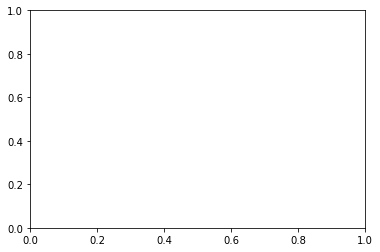

In [357]:
import seaborn as sns

global_df['qcut'] = pd.qcut(global_df['z_distance'], 15, labels=False)

# print(global_df[global_df['action_code'].isin([1])]['qcut'].value_counts())
# print(global_df[global_df['action_code'].isin([4])]['qcut'].value_counts())

global_df[global_df['action_code'].isin([1, 4])]['qcut'].plot(hue ="action_code")

In [295]:
prediction = [get_prediction(row) for index, row in global_df.iterrows()]
answer = [row['action_code'] for index, row in global_df.iterrows()]

Res = pd.DataFrame({'answer' : answer, 'action' : prediction})

Res[Res['answer'] != Res['action']][Res['answer'] == 4]['action'].value_counts()

# Res.head(10)

<ipython-input-295-6586f0200c17>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Res[Res['answer'] != Res['action']][Res['answer'] == 4]['action'].value_counts()


1    58
3    24
0    18
2    15
Name: action, dtype: int64

Проверим качество нашей модели на тренировочных данных (на данных из открытой папки)

In [274]:
from sklearn.metrics import accuracy_score

accuracy_score(Res['answer'], Res['action'])

0.6630007855459544

В тренировочной папке количество треков разных типов несбалансировано, поэтому для корректной оценки качества нашей модели будем проверять качество модели на таком же распределении треков, как и в тестовой выборке:

* 18% - стояние
* 18 % - ходьба
* 18 % - бег
* 18 % - подъем по лестнице
* 18 % - велосипед
* 10% - другие типы движений

In [592]:
Res['answer'].value_counts(), len(Res)

( 1    319
  0    302
  2    238
  4    233
 -1     62
  3     57
  5     31
  6     13
  7     13
  8     12
 Name: answer, dtype: int64,
 1280)

In [579]:
import random

ind_0 = random.sample(Res[Res.answer == 0].index.tolist(), 32)
ind_1 = random.sample(Res[Res.answer == 1].index.tolist(), 32)
ind_2 = random.sample(Res[Res.answer == 2].index.tolist(), 32)
ind_3 = random.sample(Res[Res.answer == 3].index.tolist(), 32)
ind_4 = random.sample(Res[Res.answer == 4].index.tolist(), 32)
ind_5 = random.sample(Res[Res.answer == 5].index.tolist(), 6)
ind_6 = random.sample(Res[Res.answer == 6].index.tolist(), 6)
ind_7 = random.sample(Res[Res.answer == 7].index.tolist(), 6)

ind_balanced = ind_0 + ind_1 + ind_2 + ind_3 + ind_4 + ind_5 + ind_6 + ind_7 
len(ind_balanced)

178

In [580]:
Res_balanced = Res.iloc[ind_balanced]

In [581]:
accuracy_score(Res_balanced['answer'], Res_balanced['action'])

0.47191011235955055

In [402]:
track_nums, prediction = list(zip(*sorted([(int(row['index_num']), get_prediction(row)) for _, row in global_df.iterrows()])))

In [403]:
print(len(Data), len(prediction), len(track_nums))
Res = pd.DataFrame({'track_num' : track_nums, 'action' : prediction})
Res.head(10)

146 146 146


,track_num,action
0,0,4
1,1,1
2,2,3
3,3,2
4,4,1
5,5,4
6,6,3
7,7,2
8,8,3
9,9,0


In [404]:
Res.to_csv("submit.csv", index=False)